# Exercise 1: The Driven Pendulum

We are tasked with solving the ODE of a driven real pendulum.

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

## Core Task 1

Solve the equation with scipy. The equation is written 
$$ \frac{d^2 \theta}{dt^2} = -\sin{\theta} - q \frac{d\theta}{dt} + F\sin{\Omega_D t} $$

Where
\begin{aligned}
  \Omega_D &= \frac{2}{3} \mathrm{rad \cdot s^{-1}} \\
  \dot{\theta}(t = 0) &= \omega_0 \\
  \theta(t = 0) &= \theta_0
\end{aligned}

We can define $y_0 = \theta$, $y_1 = \dot{\theta}$, and reduce the equation to
\begin{aligned}
  \dot{y_0} &= y_1 \\
  \dot{y_1} &= -\sin{\theta} - q y_1 + F\sin{\Omega_D t}
\end{aligned}

Let's now get this into the code.

In [2]:
def derivatives_real(t, y, F, q, Omega_D = 2 / 3):
    """!
    @brief Return the derivatives for the driven real pendulum equation

    @param t time
    @param y angular displacement and its derivative
    @param F driving intensity
    @param q dissipation intensity
    @param Omega_D driving frequency
    """
    return [y[1], -np.sin(y[0]) - q * y[1] + F * np.sin(Omega_D * t)]

def derivatives_small_angle(t, y, F, q, Omega_D = 2 / 3) -> list:
    """!
    @brief Return the derivatives for the driven pendulum equation under small
    angle approximation.
    
    @param t time
    @param y angular displacement and its derivative
    @param F driving intensity
    @param q dissipation intensity
    @param Omega_D driving frequency

    @return list of derivatives
    """
    return [y[1], -y[0] - q * y[1] + F * np.sin(Omega_D * t)]

Test case: $q = F = 0$, final time $t_f = \left[10, 100, 1000, 10000\right] * 2\pi$

$(\theta_0, \omega_0) = (0.01, 0)$

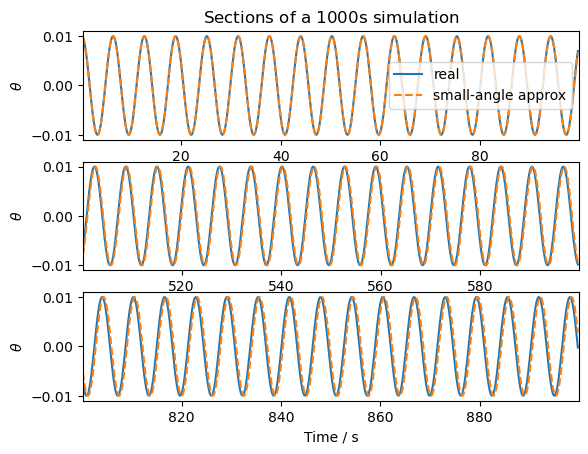

In [3]:
# t_f = np.array([10, 100, 1000]) * 2 * np.pi
# t = 1000 is not plotted as it's too cluttered. However, we observe that the
# amplitude stays constant throughout.

def get_ind_range_from_times(range_l, range_r, x) -> tuple:
    """!
    @brief get indices in x (list of times) that corresponds to limits provided.

    @param range_l left limit for time
    @param range_r right limit for time
    @param x list of times

    @return tuple containing range in indices
    """
    ind_l = next(ind for ind, t in enumerate(x) if t > range_l)  
    ind_r = next(ind for ind, t in enumerate(x) if t > range_r) - 1
    return ind_l, ind_r

def test_1():
    t_f = 1000 * 2 * np.pi
    theta_0 = 0.01
    theta_d = 0 # derivative
    samples = 30000
    solution_real = solve_ivp(
        fun = derivatives_real,
        t_span = (0, t_f),
        y0 = (theta_0, theta_d),
        args = (0, 0, ),
        t_eval = np.linspace(0, t_f, samples)
    )
    real_x, real_y = solution_real.t, solution_real.y[0]
    real_dydx = solution_real.y[1]

    small_y = theta_0 * np.cos(real_x)

    range_list = [[0, 100], [500, 600], [800, 900]]
    for i in range(1, len(range_list) + 1):
        range_l, range_r = range_list[i - 1]
        ind_l, ind_r = get_ind_range_from_times(range_l, range_r, real_x)
        plt.subplot(len(range_list), 1, i) 
        plt.ylabel('$\\theta$')
        plt.plot(real_x[ind_l : ind_r],
                 real_y[ind_l : ind_r],
                 label = "real",
                 alpha = 1)
        plt.plot(real_x[ind_l : ind_r],
                 small_y[ind_l : ind_r],
                 label = "small-angle approx",
                 alpha = 1,
                 linestyle = '--')
        plt.xlim(real_x[ind_l], real_x[ind_r])

    plt.subplot(len(range_list), 1, 1)
    plt.title("Sections of a $1000 \\mathrm{s}$ simulation")
    plt.legend()

    plt.subplot(len(range_list), 1, len(range_list))
    plt.xlabel("Time / s")
    plt.show()

test_1()

**Test for energy conservation.** The total energy, in this case, is
\begin{aligned}
  E_{t} &= \frac{1}{2} ml^2 \dot{\theta}^2 - mgl\cos{\theta} \\
        &= ml^2\left(\frac{1}{2}\dot{\theta}^2 - \frac{g}{l}
        \cos{\theta}\right) \\
        &\propto \left(\frac{1}{2}\dot{\theta}^2 - \cos{\theta}\right) 
\end{aligned}

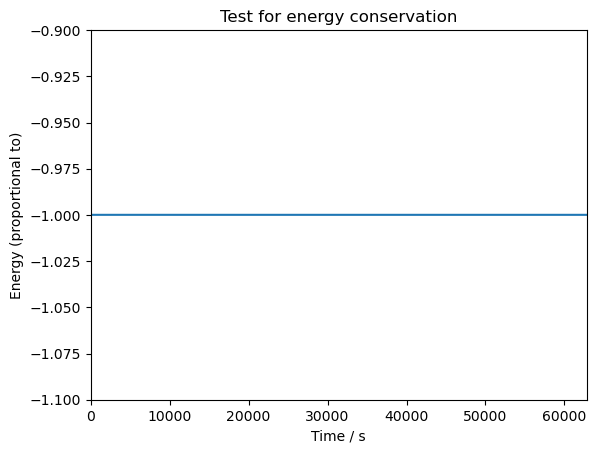

In [4]:
def get_energy(y, dydx):
    """!
    @brief returns the energy, ignoring constants, at an instance in time

    @param y angular displacement
    @param dydx angular velocity
    """
    return 1/2 * (dydx ** 2) - np.cos(y)

def test_2_energy_conservation():
    theta_0 = 0.01
    theta_d = 0
    t_f = 10000 * 2 * np.pi # 10000 cycles
    samples = 10000 * 2 * 20
    solution = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (0, 0, ),
            t_eval = np.linspace(0, t_f, samples)
        )
    real_x, real_y, real_dydx = solution.t, solution.y[0], solution.y[1]
    energy = get_energy(real_y, real_dydx)
    plt.plot(real_x, energy)
    plt.xlim(0, t_f)
    plt.ylim(-1.1, -0.9)
    plt.xlabel("Time / s")
    plt.ylabel("Energy (proportional to)")
    plt.title("Test for energy conservation")
    plt.show()

test_2_energy_conservation()


**Finding the period**. For this we use the same technique, varying the
initial $\theta_0$ from $0.001$ to $\pi - 0.001$ with $1000$ steps in the
middle.

There is no gain in simulating multiple cycles and taking averages, since we
are not subject to experimental random errors that can be thus eliminated.
Repeating for multiple cycles merely increases error in simulation and energy
and that is undesirable.

Instead we consider the period to be twice the time it takes for the pendulum
to reach the same angle on the other side. This has the advantage of avoiding
simulation errors close to $\pi$ where the algorithm finds that the pendulum
will go over the top to the other side.

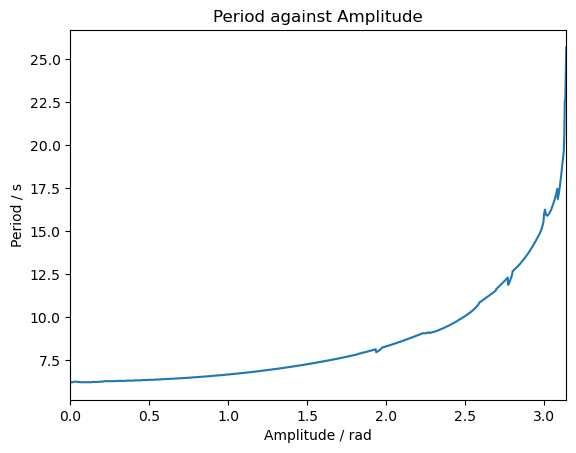

For amplitude of pi / 2: 7.39919061826579


In [5]:
def find_half_period(theta_0, y, dydx):
    for i in range(len(dydx) - 1):
        if y[i] <= -theta_0:
            return i
        if dydx[i] <= 0 and dydx[i + 1] >= 0:
            return i
    raise Exception('unable to find half-period.')

def get_period_for_amp(theta_0):
    theta_d = 0
    # we really just want one period, but who knows how it changes near the top?
    t_f = 25 * np.pi
    time_samples = 10000
    solution = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (0, 0, ),
            t_eval = np.linspace(0, t_f, time_samples)
        )

    real_x, real_y, real_dydx = solution.t, solution.y[0], solution.y[1]

    # index when pendulum first reaches half-period point.
    half_period_ind = find_half_period(theta_0, real_y, real_dydx)

    half_period_time = real_x[half_period_ind]
    return half_period_time * 2

def plot_period_amplitude_reln():
    theta_samples = 1000
    theta_0_range = np.linspace(0.001, np.pi - 0.001, theta_samples) 
    period_list = []

    for theta_0 in theta_0_range:
        period_time = get_period_for_amp(theta_0)
        period_list.append(period_time) 
        
    plt.plot(theta_0_range, period_list)
    plt.title('Period against Amplitude')
    plt.xlabel('Amplitude / rad')
    plt.ylabel('Period / s')
    plt.xlim(0, theta_0_range[-1])
    plt.ylim(min(period_list) - 1, max(period_list) + 1)
    plt.show()

plot_period_amplitude_reln()
print(f"For amplitude of pi / 2: {get_period_for_amp(np.pi / 2)}")


**Summary**. Under no damping and no driving force conditions we studied the
real pendulum. The result under small amplitude was compared with small angle
approximation results and the agreement was good. We further tested
conservation of energy and over 10000 cycles the energy is conserved well.

We further studied the period as a function of the amplitude and observed that
the small angle approximation breaks down as the period increases radically as
we approach $\pi$. At amplitude $\frac{\pi}{2}$, the period is $7.4\mathrm{s}$.


## Core Task 2

Damped and driven oscillations. We shall study damped undriven oscillations
first. As we shall see, different choices of $q$ leads to different degrees of
damping (light $\rightarrow$ heavy).


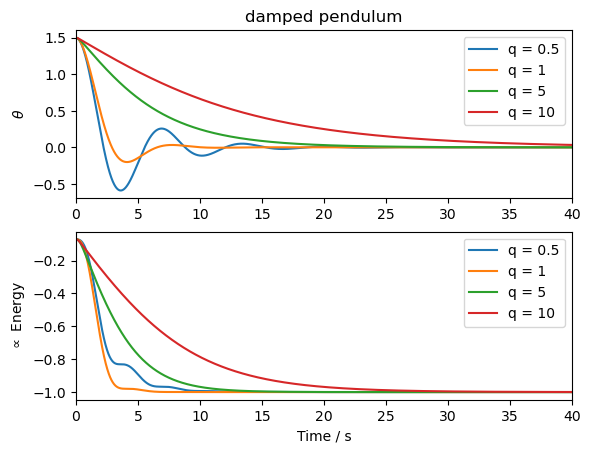

In [6]:
def plot_damped_result():
    t_f = 40
    theta_0 = 1.5
    theta_d = 0 # derivative
    samples = 5000
    q_range = [0.5, 1, 5, 10]
    F = 0
    for q in q_range:
        solution_real = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (F, q, ),
            t_eval = np.linspace(0, t_f, samples)
        )
        real_x, real_y = solution_real.t, solution_real.y[0]
        real_dydx = solution_real.y[1]
        energy = get_energy(real_y, real_dydx)

        plt.subplot(2, 1, 1)
        plt.plot(real_x, real_y, label = f"q = {q}")

        plt.subplot(2, 1, 2)
        plt.plot(real_x, energy, label = f"q = {q}")

    plt.subplot(2, 1, 1)
    plt.title(f"damped pendulum")
    plt.ylabel("$\\theta$")
    plt.xlim(0, t_f)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.ylabel("$\propto$ Energy")
    plt.xlabel("Time / s")
    plt.xlim(0, t_f)
    plt.legend()
    plt.show()

plot_damped_result()


We then look at driven oscillators, setting $q = 0.5$, $F = 0.5, 1.2, 1.44,
1.465$.

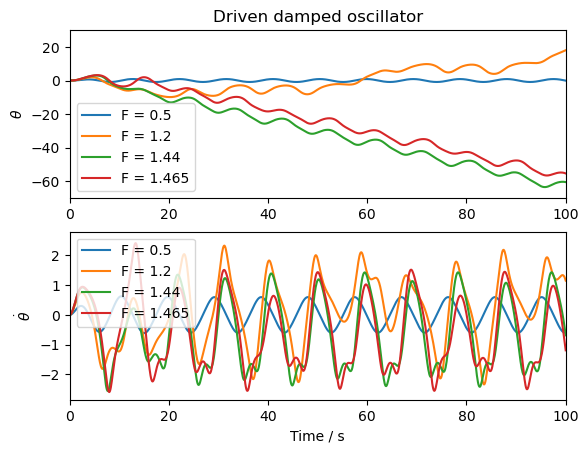

In [7]:
def plot_driven_pendulum():
    t_f = 1000
    theta_0 = 0 # driven, no need for initial decaying mode
    theta_d = 0 # derivative
    samples = 10000
    q = 0.5
    F_range = [0.5, 1.2, 1.44, 1.465]
    for F in F_range:
        solution_real = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (F, q, ),
            t_eval = np.linspace(0, t_f, samples)
        )
        real_x, real_y = solution_real.t, solution_real.y[0]
        real_dydx = solution_real.y[1]

        plt.subplot(2, 1, 1)
        plt.plot(real_x, real_y, label = f"F = {F}")
        plt.subplot(2, 1, 2)
        plt.plot(real_x, real_dydx, label = f"F = {F}")

    plt.subplot(2, 1, 1)
    plt.title("Driven damped oscillator")
    plt.ylabel("$\\theta$")
    plt.xlim(0, 100)
    plt.ylim(-70, 30)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel("Time / s")
    plt.xlim(0, 100)
    plt.ylabel('$\\dot{\\theta}$')
    plt.legend()
    plt.show()

plot_driven_pendulum()


**Conclusion**. As we can see, the period of oscillation for the driven
pendulums is about $10 \mathrm{s}$ now, which corresponds to a frequency of
$\frac{2\pi}{10} \approx \Omega_D = 2/3 \mathrm{rad \cdot s^{-1}}$.

We also note that from period to period, the detailed behaviour of the
pendulum varies, except for the $F = 0.5$ case which probably lies reasonably
well in the small angle approximation regime.


## Supplementary task 1

**Sensitivity to initial conditions**. Consider solutions to $F = 1.2$ and
$\theta_0 = 0.2$ or $\theta_0 = 0.20001$.

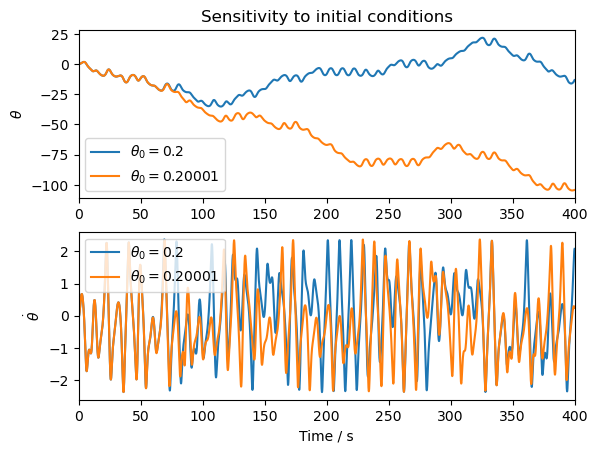

In [8]:
def sensitive_init_cond():
    t_f = 400
    theta_0_range = [0.2, 0.20001]
    theta_d = 0 # derivative
    samples = 10000
    q = 0.5
    F = 1.2
    for theta_0 in theta_0_range:
        solution_real = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (F, q, ),
            t_eval = np.linspace(0, t_f, samples)
        )
        real_x, real_y = solution_real.t, solution_real.y[0]
        real_dydx = solution_real.y[1]

        plt.subplot(2, 1, 1)
        plt.plot(real_x, real_y, label = f"$\\theta_0 = {theta_0}$")
        plt.subplot(2, 1, 2)
        plt.plot(real_x, real_dydx, label = f"$\\theta_0 = {theta_0}$")

    plt.subplot(2, 1, 1)
    plt.title("Sensitivity to initial conditions")
    plt.ylabel("$\\theta$")
    plt.xlim(0, t_f)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel("Time / s")
    plt.xlim(0, t_f)
    plt.ylabel('$\\dot{\\theta}$')
    plt.legend()
    plt.show()

sensitive_init_cond()


**Conclusion**: The two branches become widely separated at around $t = 50
\mathrm{s}$ which clearly shows the chaotic nature of this system.


## Supplementary task 2

**Phase space plots to study chaos**. We would expect to see greater chaos at
a larger values of F, since that will take the pendulum out of its small angle
regime.

Suppose the same initial conditions $\theta_0 = \dot{\theta} = 0$ but
different values of $F$.


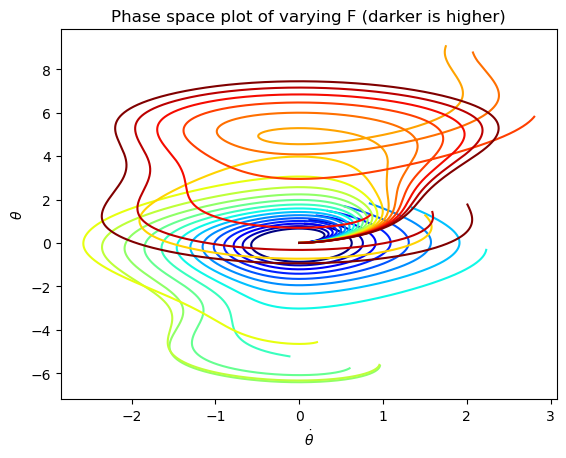

In [9]:
def plot_phase_space_F():
    t_f = 2 * np.pi * 2
    theta_0 = 0 # driven, no need for initial decaying mode
    theta_d = 0 # derivative
    samples = 10000
    q = 0.5
    sample_F = 20
    F_range = np.linspace(0.5, 2.0, sample_F)
    col = plt.cm.jet(np.linspace(0, 1, sample_F)) # colours

    for i in range(len(F_range)):
        F = F_range[i]
        solution_real = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (F, q, ),
            t_eval = np.linspace(0, t_f, samples)
        )
        real_x, real_y = solution_real.t, solution_real.y[0]
        real_dydx = solution_real.y[1]

        plt.plot(real_dydx, real_y, label = f"F = {F}", color = col[i])

    plt.title("Phase space plot of varying F (darker is higher)")
    plt.xlabel("$\\dot{\\theta}$")
    plt.ylabel("$\\theta$")

plot_phase_space_F()


Now that's been interesting. Let's try also varying initial angular
displacement.


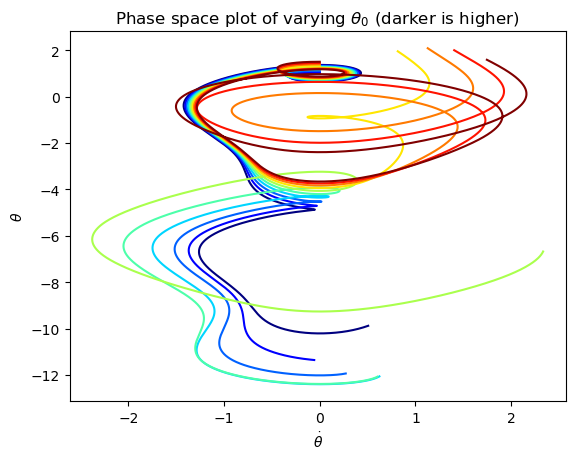

In [10]:
def plot_phase_space_theta_0():
    t_f = 2 * np.pi * 3.5
    theta_d = 0 # derivative
    samples = 10000
    q = 0.5
    F = 1.2
    sample_theta_0 = 10
    theta_0_range = np.linspace(1, 1.5, sample_theta_0)
    col = plt.cm.jet(np.linspace(0, 1, sample_theta_0)) # colours

    for i in range(len(theta_0_range)):
        theta_0 = theta_0_range[i]
        solution_real = solve_ivp(
            fun = derivatives_real,
            t_span = (0, t_f),
            y0 = (theta_0, theta_d),
            args = (F, q, ),
            t_eval = np.linspace(0, t_f, samples)
        )
        real_x, real_y = solution_real.t, solution_real.y[0]
        real_dydx = solution_real.y[1]

        plt.plot(real_dydx,
                 real_y,
                 label = f"$\\theta_0 = {theta_0}$",
                 color = col[i])

    plt.title("Phase space plot of varying $\\theta_0$ (darker is higher)")
    plt.xlabel("$\\dot{\\theta}$")
    plt.ylabel("$\\theta$")

plot_phase_space_theta_0()


**Conclusion**. We can see chaos at action: Small differences in parameter
typically lead to diverging trajectories in phase space.